In [2]:
import pandas as pd
import numpy as np
from math import floor, ceil
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mtick
import matplotlib.style as mstl
import seaborn as sns

In [3]:
mstl.use('ggplot')

In [4]:
df = pd.read_csv('nba_shots_2019.csv')

In [5]:
df1 = df[['PLAYER_NAME', 'TEAM_NAME', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_DISTANCE', 'SHOT_MADE_FLAG']].copy(deep=True)

In [6]:
df1.loc[(df1['ACTION_TYPE']=='Jump Shot')|(df1['ACTION_TYPE']=='Jump Bank Shot'), 'ACTION_TYPE'] = 'Spot-Up'
df1.loc[(df1['ACTION_TYPE']=='Putback Layup Shot')|(df1['ACTION_TYPE']=='Tip Layup Shot'), 'ACTION_TYPE'] = 'Tip-In'
df1.loc[df1['ACTION_TYPE'].str.contains('Layup'), 'ACTION_TYPE'] = 'Layup'
df1.loc[df1['ACTION_TYPE'].str.contains('Dunk'), 'ACTION_TYPE'] = 'Dunk'
df1.loc[(df1['ACTION_TYPE'].str.contains('Pull'))|(df1['ACTION_TYPE']=='Running Jump Shot'), 'ACTION_TYPE'] = 'Pullup'
df1.loc[df1['ACTION_TYPE'].str.contains('Step'), 'ACTION_TYPE'] = 'Stepback'
df1.loc[df1['ACTION_TYPE'].str.contains('Floating'), 'ACTION_TYPE'] = 'Floater'
df1.loc[df1['ACTION_TYPE'].str.contains('Hook'), 'ACTION_TYPE'] = 'Hookshot'
df1.loc[(df1['ACTION_TYPE'].str.contains('Fadeaway'))|(df1['ACTION_TYPE'].str.contains('Turnaround')),
        'ACTION_TYPE'] = 'Fadeaway'

In [7]:
df1['TEAM_NAME'].replace({'Los Angeles Lakers': 'LA Lakers', 'New York Knicks': 'NY Knicks', 'Oklahoma City Thunder': 'OKC Thunder', 'Golden State Warriors': 'GS Warriors', 'San Antonio Spurs': 'SA Spurs', 'New Orleans Pelicans': 'NO Pelicans'}, inplace=True)
df1['SHOT_TYPE'].replace({'3PT Field Goal': 3, '2PT Field Goal': 2}, inplace=True)

In [8]:
df1['POINTS'] = df1['SHOT_TYPE']*df1['SHOT_MADE_FLAG']

In [9]:
enc = pd.DataFrame(OneHotEncoder().fit_transform(df1['ACTION_TYPE'].to_frame()).toarray().astype(int))
enc.columns = sorted(df1['ACTION_TYPE'].unique())
df1 = pd.concat([df1, enc], axis=1)

In [10]:
enc2 = pd.DataFrame(OneHotEncoder().fit_transform(df1['SHOT_TYPE'].to_frame()).toarray().astype(int))
enc2.columns = sorted(df1['SHOT_TYPE'].unique())
df1 = pd.concat([df1, enc2], axis=1)

In [11]:
df1.head()

,PLAYER_NAME,TEAM_NAME,ACTION_TYPE,SHOT_TYPE,SHOT_DISTANCE,SHOT_MADE_FLAG,POINTS,Dunk,Fadeaway,Floater,Hookshot,Layup,Pullup,Spot-Up,Stepback,Tip-In,2,3
0,Robert Covington,Philadelphia 76ers,Spot-Up,3,26,0,0,0,0,0,0,0,0,1,0,0,0,1
1,Jayson Tatum,Boston Celtics,Spot-Up,3,25,0,0,0,0,0,0,0,0,1,0,0,0,1
2,Jaylen Brown,Boston Celtics,Layup,2,1,0,0,0,0,0,0,1,0,0,0,0,1,0
3,Joel Embiid,Philadelphia 76ers,Layup,2,0,1,2,0,0,0,0,1,0,0,0,0,1,0
4,Jayson Tatum,Boston Celtics,Layup,2,4,0,0,0,0,0,0,1,0,0,0,0,1,0


In [12]:
X_columns = list(df1.columns[7:])
X_columns.append('SHOT_DISTANCE')
X_fgpct_unscaled = df1[X_columns].copy()
scaler = MinMaxScaler().fit(X_fgpct_unscaled)
X_fgpct = scaler.transform(X_fgpct_unscaled)
y_fgpct = df1['SHOT_MADE_FLAG'].copy()
X_pts_att = X_fgpct
y_pts_att = df1['POINTS'].copy()

In [13]:
#X_train_fgpct, X_test_fgpct, y_train_fgpct, y_test_fgpct = train_test_split(X_fgpct, y_fgpct)
#X_train_pts_att, X_test_pts_att, y_train_pts_att, y_test_pts_att = train_test_split(X_pts_att, y_pts_att)

In [14]:
clf_fgpct = MLPRegressor((6)).fit(X_fgpct, y_fgpct)
#clf_fgpct = MLPRegressor((6)).fit(X_train_fgpct, y_train_fgpct)
clf_pts_att = MLPRegressor((6)).fit(X_pts_att, y_pts_att)
#clf_pts_att = MLPRegressor((6)).fit(X_train_pts_att, y_train_pts_att)

In [15]:
#clf_fgpct.score(X_test_fgpct, y_test_fgpct)
#clf_pts_att.score(X_test_pts_att, y_test_pts_att)

In [16]:
df2_fgpct = pd.DataFrame()
df2_fgpct['shots_made'] = df1[df1['SHOT_MADE_FLAG']==1]['PLAYER_NAME'].copy().value_counts()
df2_fgpct = df2_fgpct[df2_fgpct['shots_made']>=300]
df2_fgpct['shots_attempted'] = df1['PLAYER_NAME'].copy().value_counts()
df2_fgpct['actual_fg_percentage'] = round(df2_fgpct['shots_made']/df2_fgpct['shots_attempted']*100, 1)
df2_fgpct.sort_values('actual_fg_percentage', ascending=False, inplace=True)
df2_fgpct.index.name = 'PLAYER_NAME'
df2_fgpct.head()

,shots_made,shots_attempted,actual_fg_percentage
PLAYER_NAME,,,
Rudy Gobert,476,712,66.9
Clint Capela,474,732,64.8
JaVale McGee,400,641,62.4
Thomas Bryant,309,502,61.6
Montrezl Harrell,546,888,61.5


In [17]:
df2_fgpct_team = pd.DataFrame()
df2_fgpct_team['shots_made'] = df1[df1['SHOT_MADE_FLAG']==1]['TEAM_NAME'].copy().value_counts()
df2_fgpct_team['shots_attempted'] = df1['TEAM_NAME'].copy().value_counts()
df2_fgpct_team['actual_fg_percentage'] = round(df2_fgpct_team['shots_made']/df2_fgpct_team['shots_attempted']*100, 1)
df2_fgpct_team.sort_values('actual_fg_percentage', ascending=False, inplace=True)
df2_fgpct_team.index.name = 'TEAM_NAME'
df2_fgpct_team.head()

,shots_made,shots_attempted,actual_fg_percentage
TEAM_NAME,,,
GS Warriors,3612,7361,49.1
SA Spurs,3468,7248,47.8
Milwaukee Bucks,3555,7471,47.6
Indiana Pacers,3390,7135,47.5
Toronto Raptors,3460,7305,47.4


In [18]:
df2_pts_att = df1['PLAYER_NAME'].value_counts().to_frame('shots_attempted')
df2_pts_att.index.name = 'PLAYER_NAME'
df2_pts_att_points = df1.groupby('PLAYER_NAME')['POINTS'].sum().to_frame()
df2_pts_att = df2_pts_att.merge(df2_pts_att_points, how='left', left_index=True, right_index=True).fillna(0, downcast='infer')
df2_pts_att.reset_index(inplace=True)
df2_pts_att = df2_pts_att[df2_pts_att['PLAYER_NAME'].isin(df2_fgpct.index)]
df2_pts_att.set_index('PLAYER_NAME', inplace=True)
df2_pts_att['actual_pts_att'] = round(df2_pts_att['POINTS']/df2_pts_att['shots_attempted'], 2)
df2_pts_att.sort_values('actual_pts_att', ascending=False, inplace=True)
pts_att_avg = round(df2_pts_att['POINTS'].sum()/df2_pts_att['shots_attempted'].sum(), 2)
df2_pts_att.rename(columns={'POINTS': 'points'}, inplace=True)
df2_pts_att.head()

,shots_attempted,points,actual_pts_att
PLAYER_NAME,,,
Rudy Gobert,712,952,1.34
Thomas Bryant,502,651,1.30
Clint Capela,732,948,1.30
JaVale McGee,641,801,1.25
Joe Harris,748,931,1.24


In [19]:
for player in df2_fgpct.index:
    df3_fgpct = pd.DataFrame(clf_fgpct.predict(scaler.transform(df1[X_columns].copy())[df1['PLAYER_NAME']==player]))
    df2_fgpct.loc[player, 'predicted_fg_percentage'] = round(df3_fgpct[0].mean()*100, 1)

In [20]:
for team in df2_fgpct_team.index:
    df3_fgpct_team = pd.DataFrame(clf_fgpct.predict(scaler.transform(df1[X_columns].copy())[df1['TEAM_NAME']==team]))
    df2_fgpct_team.loc[team, 'predicted_fg_percentage'] = round(df3_fgpct_team[0].mean()*100, 1)

In [21]:
for player in df2_pts_att.index:
    df3_pts_att = pd.DataFrame(clf_pts_att.predict(scaler.transform(df1[X_columns].copy())[df1['PLAYER_NAME']==player]))
    df2_pts_att.loc[player, 'predicted_pts_att'] = round(df3_pts_att[0].mean(), 2)

In [22]:
df2_fgpct['difference'] = df2_fgpct['actual_fg_percentage']-df2_fgpct['predicted_fg_percentage']
df2_fgpct.sort_values('difference', ascending=False, inplace=True)
df2_fgpct.head()

,shots_made,shots_attempted,actual_fg_percentage,predicted_fg_percentage,difference
PLAYER_NAME,,,,,
Al Horford,387,723,53.5,45.8,7.7
Stephen Curry,632,1340,47.2,39.8,7.4
Kevin Durant,721,1383,52.1,45.1,7.0
Joe Harris,374,748,50.0,43.4,6.6
Domantas Sabonis,413,700,59.0,52.6,6.4


In [23]:
df2_fgpct_team['difference'] = df2_fgpct_team['actual_fg_percentage']-df2_fgpct_team['predicted_fg_percentage']
df2_fgpct_team.sort_values('difference', ascending=False, inplace=True)
df2_fgpct_team.head()

,shots_made,shots_attempted,actual_fg_percentage,predicted_fg_percentage,difference
TEAM_NAME,,,,,
GS Warriors,3612,7361,49.1,45.2,3.9
SA Spurs,3468,7248,47.8,44.5,3.3
Toronto Raptors,3460,7305,47.4,45.8,1.6
Boston Celtics,3451,7423,46.5,45.2,1.3
Indiana Pacers,3390,7135,47.5,46.7,0.8


In [24]:
df2_pts_att['difference'] = df2_pts_att['actual_pts_att']-df2_pts_att['predicted_pts_att']
df2_pts_att.sort_values('difference', ascending=False, inplace=True)
df2_pts_att.head()

,shots_attempted,points,actual_pts_att,predicted_pts_att,difference
PLAYER_NAME,,,,,
Stephen Curry,1340,1618,1.21,0.96,0.25
Joe Harris,748,931,1.24,1.02,0.22
Al Horford,723,847,1.17,0.98,0.19
Bryn Forbes,791,898,1.14,0.97,0.17
Klay Thompson,1402,1551,1.11,0.95,0.16


In [25]:
color_dict = {'GS Warriors': 'darkblue', 'SA Spurs': 'black', 'Toronto Raptors': 'red', 'Boston Celtics': 'green', 'Denver Nuggets': 'midnightblue', 'Houston Rockets': 'red', 'NO Pelicans': 'goldenrod', 'Indiana Pacers': 'goldenrod', 'Sacramento Kings': 'indigo', 'Orlando Magic': 'royalblue', 'Milwaukee Bucks': 'darkgreen', 'Washington Wizards': 'midnightblue', 'LA Clippers': 'red', 'Detroit Pistons': 'red', 'Utah Jazz': 'midnightblue', 'Portland Trail Blazers': 'red', 'Charlotte Hornets': 'darkcyan', 'Minnesota Timberwolves': 'limegreen', 'Brooklyn Nets': 'black', 'LA Lakers': 'indigo', 'Philadelphia 76ers': 'blue', 'Dallas Mavericks': 'royalblue', 'Memphis Grizzlies': 'midnightblue', 'Miami Heat': 'magenta', 'Cleveland Cavaliers': 'maroon', 'Phoenix Suns': 'orangered', 'Chicago Bulls': 'firebrick', 'Atlanta Hawks': 'indianred', 'OKC Thunder': 'dodgerblue', 'NY Knicks': 'orangered'}

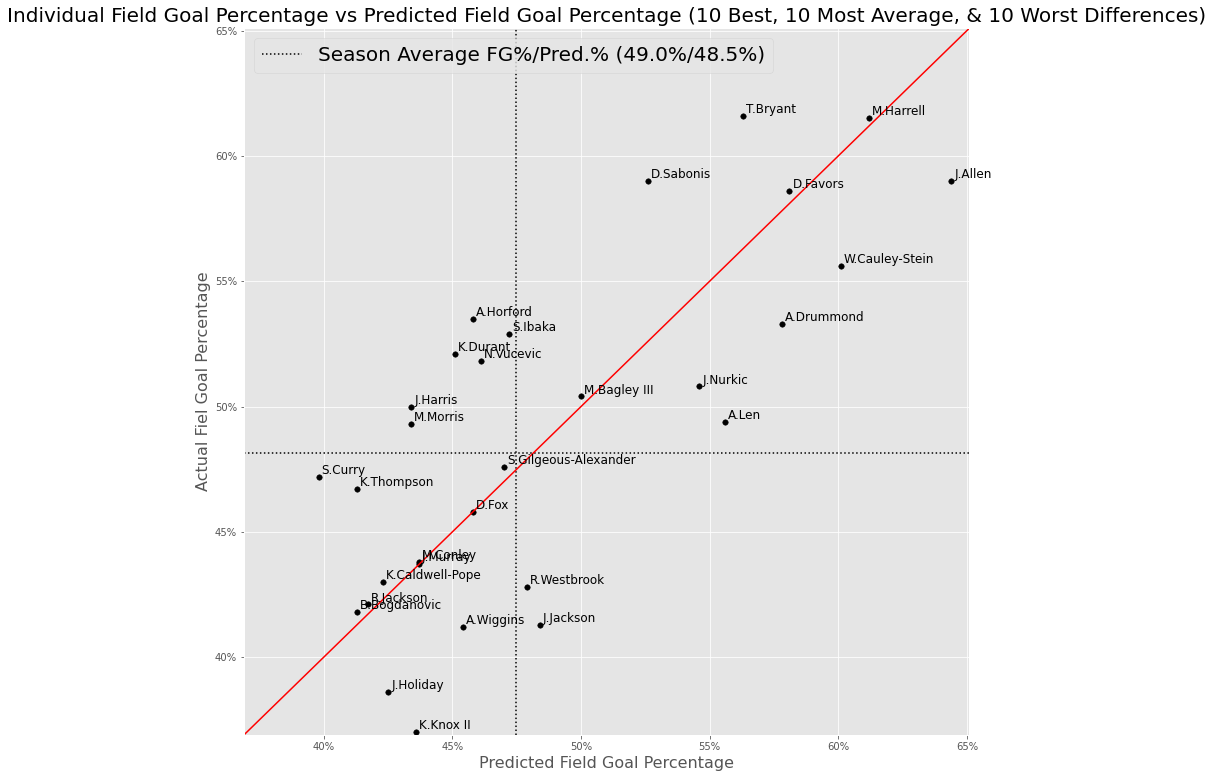

In [26]:
fig_fgpct, ax_fgpct = plt.subplots(figsize=(13, 13))
df2_fgpct_subset = pd.concat([df2_fgpct[:10], df2_fgpct[round(len(df2_fgpct)/2)-5:round(len(df2_fgpct)/2)+5], df2_fgpct[-10:]])
ax_fgpct.scatter(df2_fgpct_subset['predicted_fg_percentage'], df2_fgpct_subset['actual_fg_percentage'], s=30, color='black')
ax_fgpct.axvline(df2_fgpct['predicted_fg_percentage'].mean(), color='black', ls=':', label='Season Average FG%/Pred.% ({}%/{}%)'.format(round(df2_fgpct_subset['actual_fg_percentage'].mean(), 1), round(df2_fgpct_subset['predicted_fg_percentage'].mean(), 1)))
ax_fgpct.axhline(df2_fgpct['actual_fg_percentage'].mean(), color='black', ls=':')
ax_fgpct.set_xlabel('Predicted Field Goal Percentage', fontsize=16)
ax_fgpct.set_ylabel('Actual Fiel Goal Percentage', fontsize=16)
ax_fgpct.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax_fgpct.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax_fgpct.set_title('Individual Field Goal Percentage vs Predicted Field Goal Percentage (10 Best, 10 Most Average, & 10 Worst Differences)', fontsize=20)
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax_fgpct.transAxes
line.set_transform(transform)
ax_fgpct.add_line(line)
lim_min_fgpct = floor(min(df2_fgpct_subset['predicted_fg_percentage'].min(), df2_fgpct_subset['actual_fg_percentage'].min()))-0.1
lim_max_fgpct = ceil(max(df2_fgpct_subset['predicted_fg_percentage'].max(), df2_fgpct_subset['actual_fg_percentage'].max()))+0.1
plt.xlim(lim_min_fgpct, lim_max_fgpct)
plt.ylim(lim_min_fgpct, lim_max_fgpct)
for player in df2_fgpct_subset.index:
    ax_fgpct.annotate(player.split()[0][0]+'.'+' '.join(map(str, player.split()[1:])), (df2_fgpct_subset.loc[player, 'predicted_fg_percentage'], df2_fgpct_subset.loc[player, 'actual_fg_percentage']), size=12, xytext=(3, 3), textcoords='offset points')
ax_fgpct.legend(prop={'size': 20}, loc=2)
plt.show()

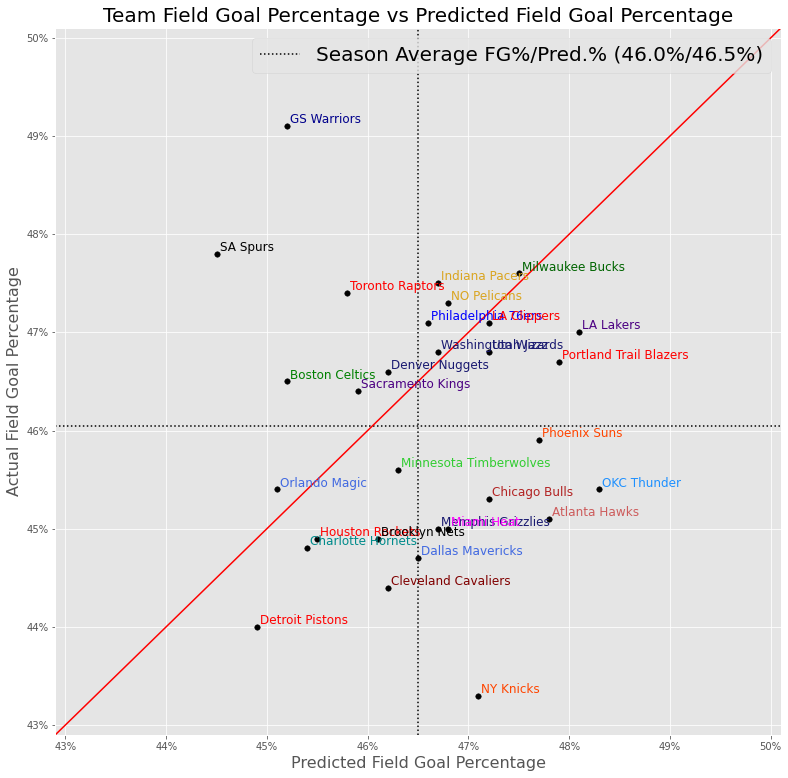

In [27]:
fig_fgpct_team, ax_fgpct_team = plt.subplots(figsize=(13, 13))
ax_fgpct_team.scatter(df2_fgpct_team['predicted_fg_percentage'], df2_fgpct_team['actual_fg_percentage'], s=30, color='black')
ax_fgpct_team.axvline(df2_fgpct_team['predicted_fg_percentage'].mean(), color='black', ls=':', label='Season Average FG%/Pred.% ({}%/{}%)'.format(round(df2_fgpct_team['actual_fg_percentage'].mean(), 1), round(df2_fgpct_team['predicted_fg_percentage'].mean(), 1)))
ax_fgpct_team.axhline(df2_fgpct_team['actual_fg_percentage'].mean(), color='black', ls=':')
ax_fgpct_team.set_xlabel('Predicted Field Goal Percentage', fontsize=16)
ax_fgpct_team.set_ylabel('Actual Field Goal Percentage', fontsize=16)
ax_fgpct_team.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax_fgpct_team.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax_fgpct_team.set_title('Team Field Goal Percentage vs Predicted Field Goal Percentage', fontsize=20)
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax_fgpct_team.transAxes
line.set_transform(transform)
ax_fgpct_team.add_line(line)
lim_min_fgpct_team = floor(min(df2_fgpct_team['predicted_fg_percentage'].min(), df2_fgpct_team['actual_fg_percentage'].min()))-0.1
lim_max_fgpct_team = ceil(max(df2_fgpct_team['predicted_fg_percentage'].max(), df2_fgpct_team['actual_fg_percentage'].max()))+0.1
plt.xlim(lim_min_fgpct_team, lim_max_fgpct_team)
plt.ylim(lim_min_fgpct_team, lim_max_fgpct_team)
for team in df2_fgpct_team.index:
    ax_fgpct_team.annotate(team, (df2_fgpct_team.loc[team, 'predicted_fg_percentage'], df2_fgpct_team.loc[team, 'actual_fg_percentage']), color=color_dict[team], size=12, xytext=(3, 3), textcoords='offset points')
ax_fgpct_team.legend(prop={'size': 20}, loc=1)
plt.show()

In [28]:
def plus_minus(num):
    if num>0: return '+'
    if num<0: return '-'
    return ''

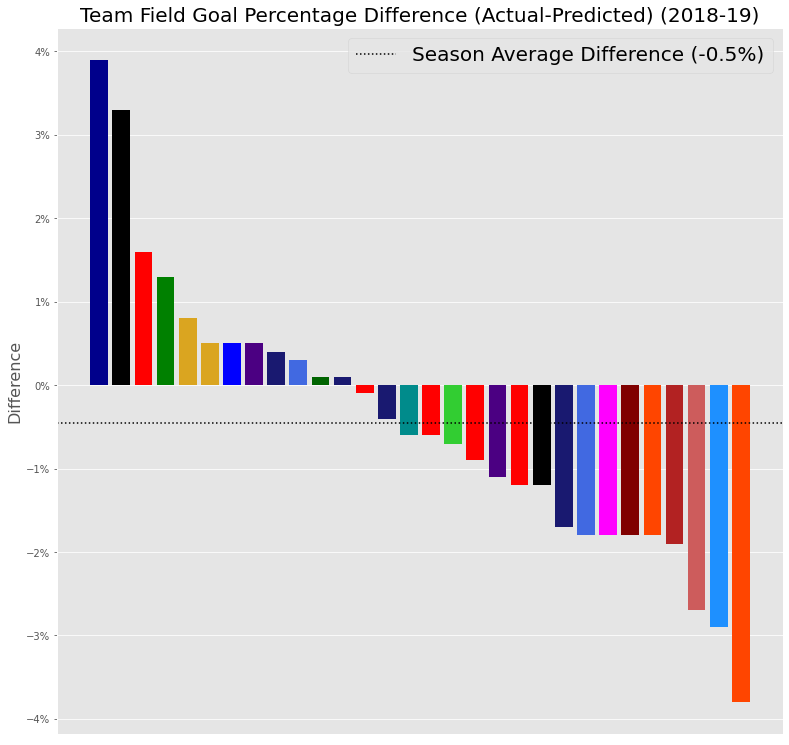

In [29]:
fig_fgpct_team_dif, ax_fgpct_team_dif = plt.subplots(figsize=(13, 13))
for team in df2_fgpct_team.index:
    ax_fgpct_team_dif.bar(team, df2_fgpct_team.loc[team, 'difference'], color=color_dict[team])
ax_fgpct_team_dif.axhline(df2_fgpct_team['difference'].mean(), color='black', ls=':', label='Season Average Difference ({}{}%)'.format(plus_minus(round(df2_fgpct_team['difference'].mean(), 1)), abs(round(df2_fgpct_team['difference'].mean(), 1))))
ax_fgpct_team_dif.set_xlabel('Team', fontsize=16)
ax_fgpct_team_dif.set_ylabel('Difference', fontsize=16)
ax_fgpct_team_dif.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax_fgpct_team_dif.set_title('Team Field Goal Percentage Difference (Actual-Predicted) (2018-19)', fontsize=20)
ax_fgpct_team_dif.get_xaxis().set_visible(False)
ax_fgpct_team_dif.legend(prop={'size': 20})
plt.show()

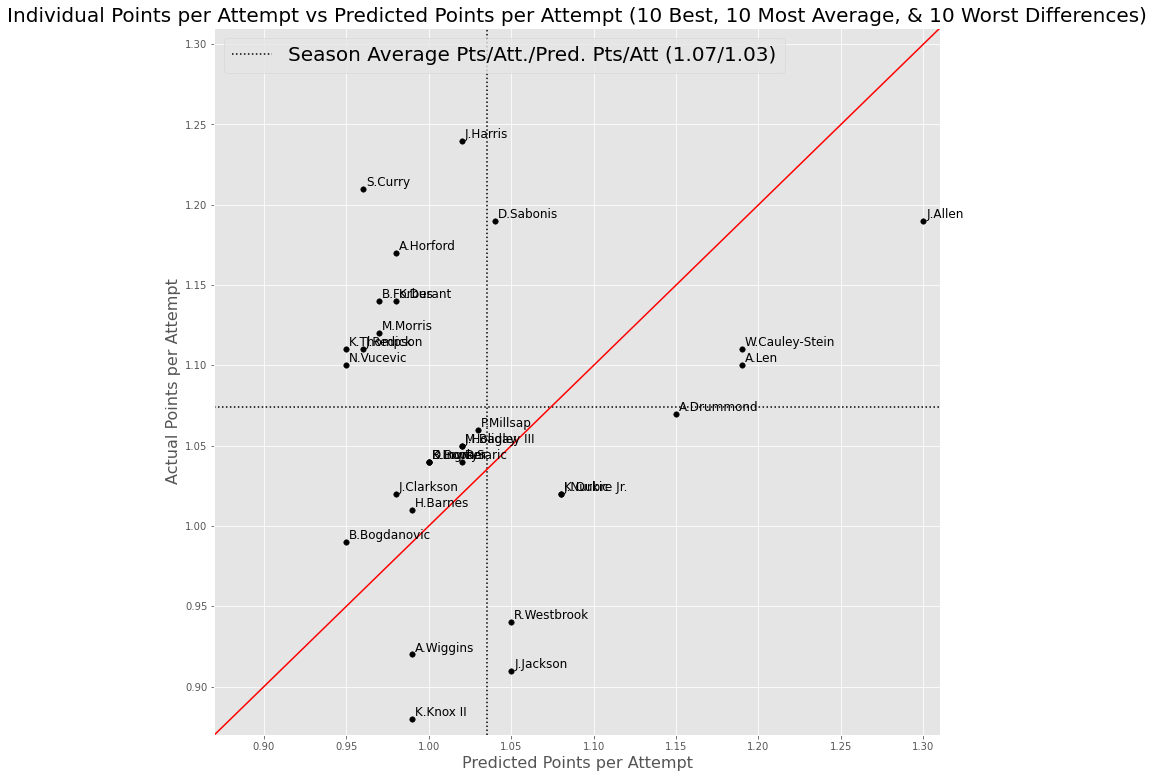

In [30]:
fig_pts_att, ax_pts_att = plt.subplots(figsize=(13, 13))
df2_pts_att_subset = pd.concat([df2_pts_att[:10], df2_pts_att[round(len(df2_pts_att)/2)-5:round(len(df2_pts_att)/2)+5], df2_pts_att[-10:]])
ax_pts_att.scatter(df2_pts_att_subset['predicted_pts_att'], df2_pts_att_subset['actual_pts_att'], s=30, color='black')
ax_pts_att.axvline(df2_pts_att['predicted_pts_att'].mean(), color='black', ls=':', label='Season Average Pts/Att./Pred. Pts/Att ({}/{})'.format(round(df2_pts_att_subset['actual_pts_att'].mean(), 2), round(df2_pts_att_subset['predicted_pts_att'].mean(), 2)))
ax_pts_att.axhline(df2_pts_att['actual_pts_att'].mean(), color='black', ls=':')
ax_pts_att.set_xlabel('Predicted Points per Attempt', fontsize=16)
ax_pts_att.set_ylabel('Actual Points per Attempt', fontsize=16)
ax_pts_att.set_title('Individual Points per Attempt vs Predicted Points per Attempt (10 Best, 10 Most Average, & 10 Worst Differences)', fontsize=20)
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax_pts_att.transAxes
line.set_transform(transform)
ax_pts_att.add_line(line)
lim_min_pts_att = min(df2_pts_att_subset['predicted_pts_att'].min(), df2_pts_att_subset['actual_pts_att'].min())-0.01
lim_max_pts_att = max(df2_pts_att_subset['predicted_pts_att'].max(), df2_pts_att_subset['actual_pts_att'].max())+0.01
plt.xlim(lim_min_pts_att, lim_max_pts_att)
plt.ylim(lim_min_pts_att, lim_max_pts_att)
for player in df2_pts_att_subset.index:
    ax_pts_att.annotate(player.split()[0][0]+'.'+' '.join(map(str, player.split()[1:])), (df2_pts_att_subset.loc[player, 'predicted_pts_att'], df2_pts_att_subset.loc[player, 'actual_pts_att']), size=12, xytext=(3, 3), textcoords='offset points')
ax_pts_att.legend(prop={'size': 20}, loc=2)
plt.show()

In [31]:
df2 = df1['SHOT_DISTANCE'].value_counts().to_frame('ATTEMPTS')
df2.index.name = 'SHOT_DISTANCE'
df2_makes = df1.groupby('SHOT_DISTANCE')['SHOT_MADE_FLAG'].value_counts().to_frame()
df2_makes.columns=['MAKES']
df2_makes.reset_index(level=1, inplace=True)
df2_makes = df2_makes[df2_makes['SHOT_MADE_FLAG']==1]
df2_makes.drop(columns='SHOT_MADE_FLAG', inplace=True)
df2 = df2.merge(df2_makes, how='left', left_index=True, right_index=True).fillna(0, downcast='infer')
df2['PERCENTAGE'] = round(df2['MAKES']/df2['ATTEMPTS']*100, 1)
df2.sort_index(inplace=True)
df2.head()

,ATTEMPTS,MAKES,PERCENTAGE
SHOT_DISTANCE,,,
0,19532,14415,73.8
1,27481,18794,68.4
2,17084,8934,52.3
3,8330,3431,41.2
4,5593,2152,38.5


In [32]:
df3 = df1['ACTION_TYPE'].value_counts().to_frame('ATTEMPTS')
df3.index.name = 'ACTION_TYPE'
df3_makes = df1.groupby('ACTION_TYPE')['SHOT_MADE_FLAG'].value_counts().to_frame()
df3_makes.columns=['MAKES']
df3_makes.reset_index(level=1, inplace=True)
df3_makes = df3_makes[df3_makes['SHOT_MADE_FLAG']==1]
df3_makes.drop(columns='SHOT_MADE_FLAG', inplace=True)
df3 = df3.merge(df3_makes, how='left', left_index=True, right_index=True).fillna(0, downcast='infer')
df3['PERCENTAGE'] = round(df3['MAKES']/df3['ATTEMPTS']*100, 1)
df3.sort_values('PERCENTAGE', ascending=False, inplace=True)
df3.head()

,ATTEMPTS,MAKES,PERCENTAGE
ACTION_TYPE,,,
Dunk,12735,11394,89.5
Layup,53303,29221,54.8
Tip-In,7629,4172,54.7
Hookshot,8452,4022,47.6
Floater,14550,6500,44.7


In [33]:
df4 = df1['ACTION_TYPE'].value_counts().to_frame('ATTEMPTS')
df4.index.name = 'ACTION_TYPE'
df4_points = df1.groupby('ACTION_TYPE')['POINTS'].sum().to_frame()
df4 = df4.merge(df4_points, how='left', left_index=True, right_index=True).fillna(0, downcast='infer')
df4['PTS/ATT'] = round(df4['POINTS']/df4['ATTEMPTS'], 2)
df4.sort_values('PTS/ATT', ascending=False, inplace=True)
df4.head()

,ATTEMPTS,POINTS,PTS/ATT
ACTION_TYPE,,,
Dunk,12735,22788,1.79
Layup,53303,58442,1.10
Tip-In,7629,8344,1.09
Stepback,7931,7998,1.01
Spot-Up,78460,77446,0.99


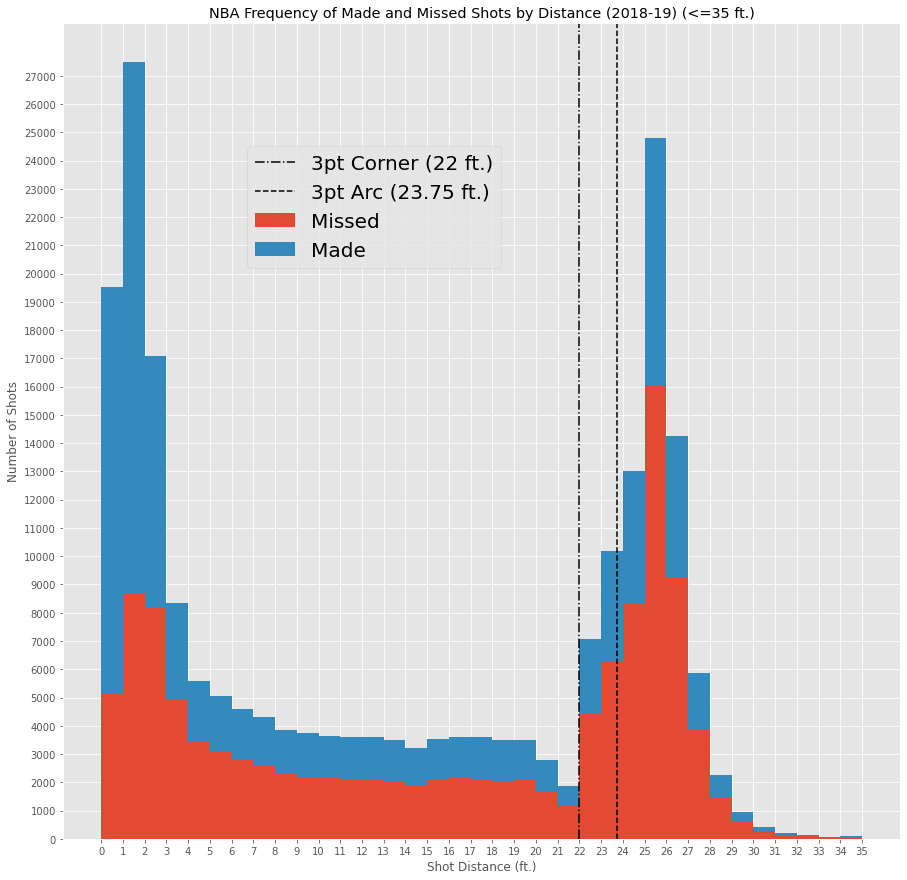

In [34]:
fig1, ax1 = plt.subplots(figsize=(15, 15))
ax1.hist([df1[(df1['SHOT_MADE_FLAG']==0)&(df1['SHOT_DISTANCE']<=35)]['SHOT_DISTANCE'], df1[(df1['SHOT_MADE_FLAG']==1)&(df1['SHOT_DISTANCE']<=35)]['SHOT_DISTANCE']],
        bins=np.arange(0, 36, 1), stacked=True, label=['Missed', 'Made'])
ax1.axvline(22, color='black', ls='-.', label='3pt Corner (22 ft.)')
ax1.axvline(23.75, color='black', ls='--', label='3pt Arc (23.75 ft.)')
ax1.set_xticks(np.arange(0, 36, 1))
ax1.set_yticks(np.arange(0, 27001, 1000))
ax1.set_xlabel('Shot Distance (ft.)')
ax1.set_ylabel('Number of Shots')
ax1.set_title('NBA Frequency of Made and Missed Shots by Distance (2018-19) (<=35 ft.)')
ax1.legend(prop={'size': 20}, loc=(0.22, 0.7))
plt.show()

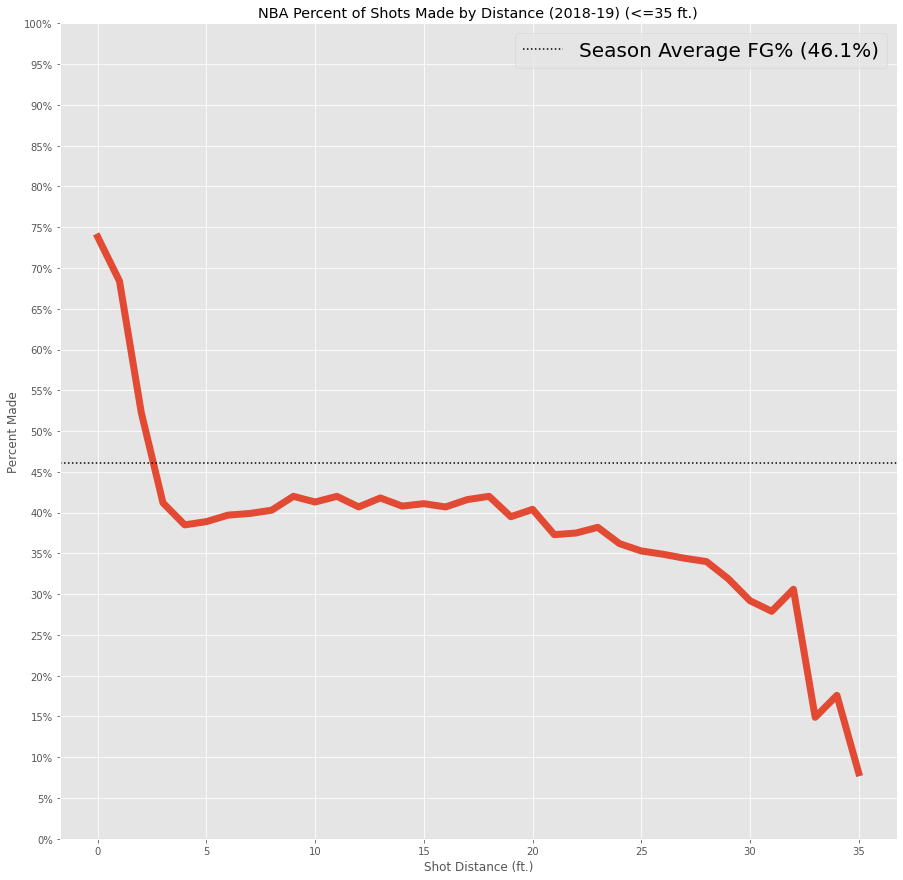

In [35]:
fig2, ax2 = plt.subplots(figsize=(15, 15))
ax2.plot(df2[df2.index<=35]['PERCENTAGE'], lw=7)
ax2.axhline(46.1, color='black', ls=':', label='Season Average FG% ({}%)'.format(round(df2['MAKES'].sum()/df2['ATTEMPTS'].sum()*100, 1)))
ax2.set_xticks(np.arange(0, 36, 5))
ax2.set_yticks(np.arange(0, 101, 5))
ax2.set_xlabel('Shot Distance (ft.)')
ax2.set_ylabel('Percent Made')
ax2.set_title('NBA Percent of Shots Made by Distance (2018-19) (<=35 ft.)')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.legend(prop={'size': 20})
plt.show()

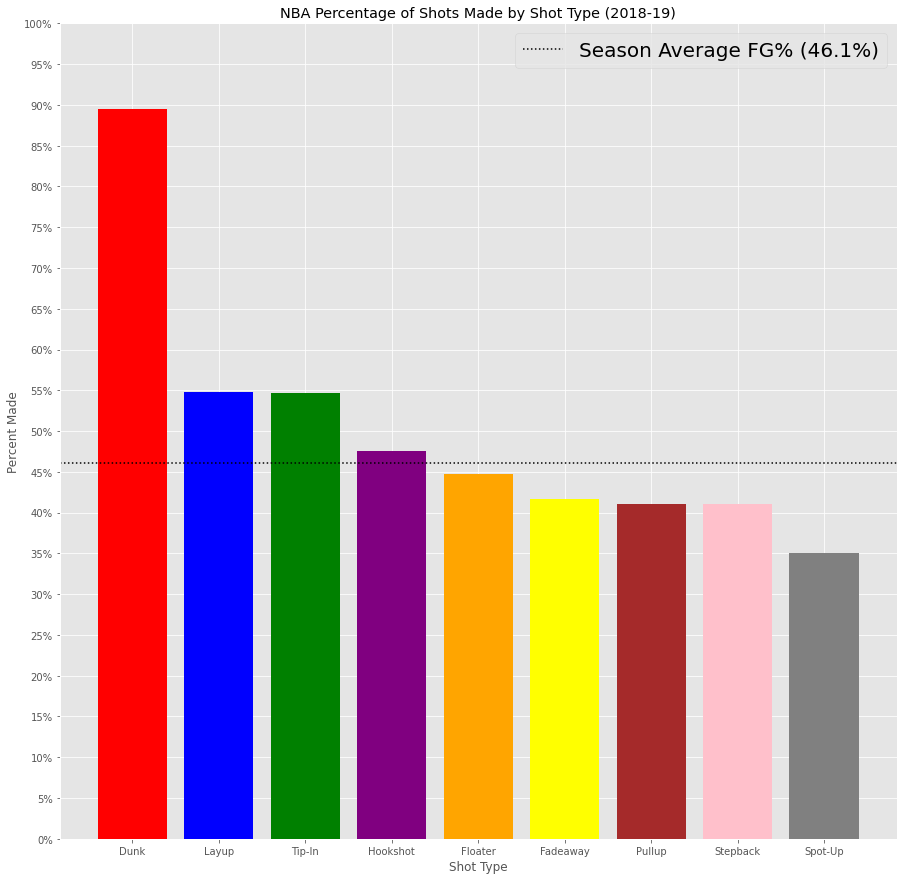

In [36]:
fig3, ax3 = plt.subplots(figsize=(15, 15))
ax3.bar(df3.index, df3['PERCENTAGE'], color=['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'brown', 'pink', 'gray'])
ax3.axhline(46.1, color='black', ls=':', label='Season Average FG% ({}%)'.format(round(df2['MAKES'].sum()/df2['ATTEMPTS'].sum()*100, 1)))
ax3.set_yticks(np.arange(0, 101, 5))
ax3.set_xlabel('Shot Type')
ax3.set_ylabel('Percent Made')
ax3.set_title('NBA Percentage of Shots Made by Shot Type (2018-19)')
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.legend(prop={'size': 20})
plt.show()

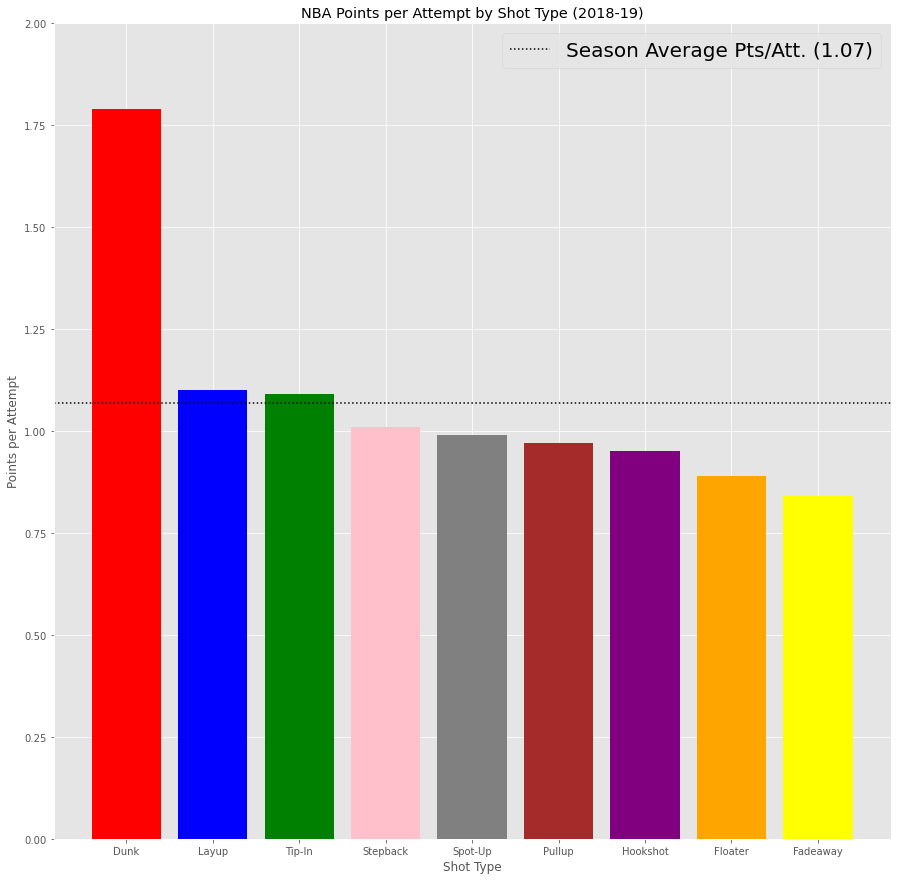

In [37]:
fig5, ax5 = plt.subplots(figsize=(15, 15))
ax5.bar(df4.index, df4['PTS/ATT'], color=['red', 'blue', 'green', 'pink', 'gray', 'brown', 'purple', 'orange', 'yellow'])
ax5.axhline(pts_att_avg, color='black', ls=':', label='Season Average Pts/Att. ({})'.format(pts_att_avg))
ax5.set_yticks(np.arange(0, 2.25, 0.25))
ax5.set_xlabel('Shot Type')
ax5.set_ylabel('Points per Attempt')
ax5.set_title('NBA Points per Attempt by Shot Type (2018-19)')
ax5.legend(prop={'size': 20})
plt.show()

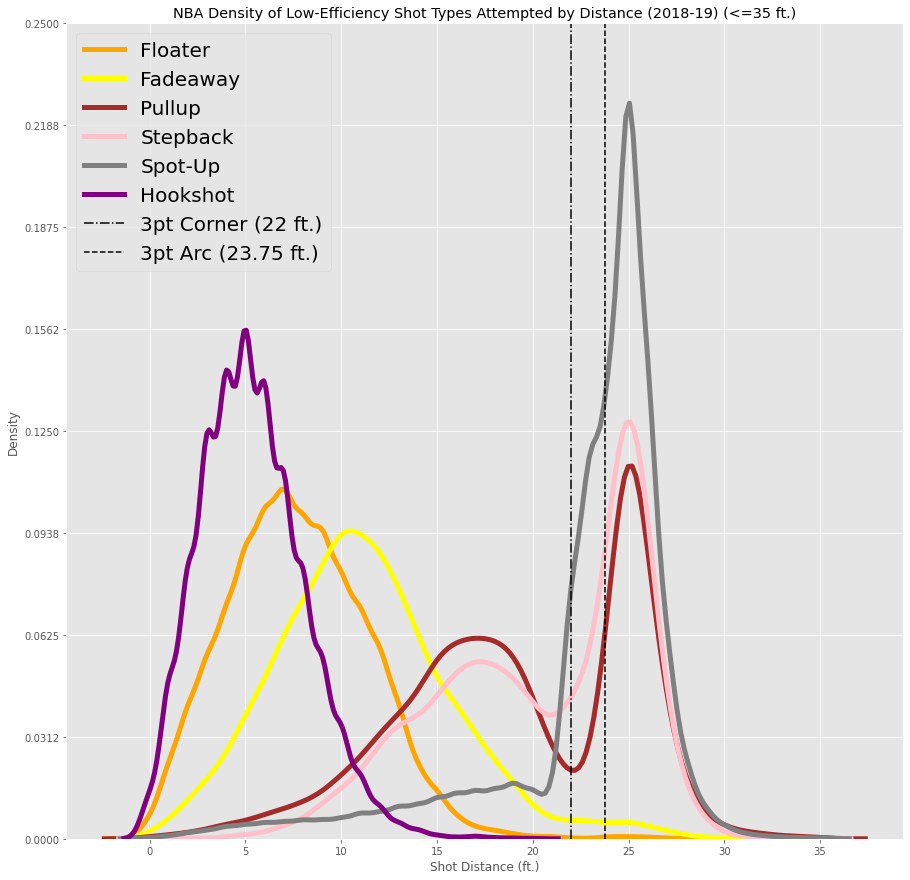

In [38]:
fig4, ax4 = plt.subplots(figsize=(15, 15))
color = ['orange', 'yellow', 'brown', 'pink', 'gray', 'purple']
for i, shot in enumerate(['Floater', 'Fadeaway', 'Pullup', 'Stepback', 'Spot-Up', 'Hookshot']):
    sns.kdeplot(df1[(df1['ACTION_TYPE']==shot)&(df1['SHOT_DISTANCE']<=35)]['SHOT_DISTANCE'], lw=5, color=color[i], label=shot, ax=ax4)
ax4.axvline(22, color='black', ls='-.', label='3pt Corner (22 ft.)')
ax4.axvline(23.75, color='black', ls='--', label='3pt Arc (23.75 ft.)')
ax4.set_xticks(np.arange(0, 36, 5))
ax4.set_yticks(np.arange(0, 0.28125, 0.03125))
ax4.set_xlabel('Shot Distance (ft.)')
ax4.set_title('NBA Density of Low-Efficiency Shot Types Attempted by Distance (2018-19) (<=35 ft.)')
ax4.legend(prop={'size': 20})
plt.show()